In [1]:
#Import necessary dependencies or frameworks or libraries
from plotly import graph_objs as go;import copy; import datetime;import gc; gc.collect()
import numpy as np;import pandas as pd, os, gc;import seaborn as sns;from tqdm import tqdm; import missingno as msno
from sklearn.model_selection import KFold,cross_val_score,GroupKFold,RepeatedKFold,StratifiedKFold,GridSearchCV,cross_validate
import plotly.express as px;import math
from scipy import stats;import statsmodels.api as sm;from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time;import warnings;from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split; from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer; import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, log_loss;from sklearn.feature_selection import mutual_info_classif
import lightgbm as lgb;from sklearn import metrics; from scipy.optimize import minimize
from lightgbm import LGBMClassifier; from catboost import CatBoostClassifier
warnings.filterwarnings('ignore')
from typing import List
import perfplot

In [2]:
#Data path & csv files name extension
data_path='/Users/DELL/Desktop/Hackhathons/Kowope/Data/'
train='Train.csv';test='Test.csv';submission ='SampleSubmission.csv'

In [3]:
#define some fxn to read the data set
def read_train():
    train_data =pd.read_csv(data_path + train)
    return train_data
def read_test():
    test_data =pd.read_csv(data_path + test)
    return test_data
def read_submission():
    sample_submission =pd.read_csv(data_path + submission)
    return sample_submission
#Assign defined fxns to variables
train = read_train();test=read_test();submission=read_submission()

In [4]:
test=test.copy()

In [5]:
test_id=test['Applicant_ID']

In [6]:
train['default_status']= train['default_status'].replace({'yes': 1,'no': 0})

In [7]:
train.fillna(-999, inplace=True)
test.fillna(-999, inplace=True)

In [8]:
train['loans_behaviour']=train['form_field3'] - (train['form_field4'] +train['form_field5'])

In [9]:
train.drop(['Applicant_ID'], axis=1, inplace =True)
test.drop(['Applicant_ID'], axis=1, inplace =True)

In [10]:
features=['form_field1','form_field2'] #add field12

In [11]:
data=pd.concat([train,test],sort=False).reset_index(drop=True)

In [12]:
data['form_field28'].max()

60772.0

In [13]:
def chdx(data):
    if data.form_field1 <=3450:
        return 'ff-seg1'
    else:
        return 'ff-seg2'
data['ff1'] = data.apply(lambda data:chdx(data), axis=1)

In [14]:
def chdx2(data):
    if data.form_field30 <=5000:
        return 'ff-seg30'
    else:
        return 'ff-seg30x'
data['ff30'] = data.apply(lambda data:chdx2(data), axis=1)

In [15]:
def chdx3(data):
    if data.form_field42 <=0.30:
        return 'ff-seg42'
    elif data.form_field42 >0.30 and data.form_field42 <=1.50:
        return 'ff-seg42x'
    else:
        return 'ff-seg42xx'
data['ff42'] = data.apply(lambda data:chdx3(data), axis=1)

In [16]:
data['form_field28']=np.log(data['form_field28'])
data['form_field13']=np.log(data['form_field13'])
data['form_field27']=np.log(data['form_field27'])
data['form_field29']=np.log(data['form_field29'])
data['form_field1']=np.log(data['form_field1'])

In [17]:
def aggregate_features(x,col_name):
    x["min_"+col_name]=x[col_name].apply(np.min)
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    return x  

In [18]:
for col_name in tqdm(features):
    data=aggregate_features(data,col_name)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.30s/it]


In [19]:
#NEW

In [20]:
credit_card_clusters=['form_field6','form_field7','form_field8','form_field9','form_field10',
                      'form_field14','form_field15','form_field11','form_field12','form_field16','form_field17'
                     ,'form_field18','form_field19','form_field20','form_field21','form_field22','form_field23','form_field24'
                     ,'form_field25','form_field26']

In [21]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_std = sc.fit_transform(data[credit_card_clusters])
pca = decomposition.PCA(n_components=3)
X_std_pca = pca.fit_transform(X_std)

In [22]:
data["pc1"] = 0
data["pc2"] = 0
data["pc3"] = 0
data[["pc1","pc2","pc3"]] = X_std_pca

In [23]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=1996).fit(data[credit_card_clusters])
data["kmeans"] = kmeans.predict(data[credit_card_clusters])

In [24]:
train=data[data.default_status.notnull()].reset_index(drop=True)
test=data[data.default_status.isna()].reset_index(drop=True)

In [25]:
test=test.drop(['default_status'], axis=1)

In [26]:
X=train.drop(['default_status'], axis=1)
y=train.default_status

In [27]:
test.shape

(24000, 63)

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=12345)

In [29]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

In [30]:
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
errcb=[]
y_pred_totcb=[]
fold=StratifiedKFold(n_splits=10, random_state=123456, shuffle=True)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = CatBoostClassifier(eval_metric='AUC', learning_rate=0.03,  depth=6, iterations=1500,use_best_model=True)
    m.fit(X_train,y_train,cat_features=categorical_features_indices,eval_set=[(X_train,y_train),(X_val, y_val)],verbose=100, early_stopping_rounds=100)#,verbose=100)
    preds=m.predict_proba(X_test)[:, 1]
    print("err: ",roc_auc_score(y_test,preds))
    errcb.append(roc_auc_score(y_test,preds))
    p = m.predict_proba(test)[:, 1]
    y_pred_totcb.append(p)

0:	test: 0.7885375	test1: 0.7968314	best: 0.7968314 (0)	total: 294ms	remaining: 7m 20s
100:	test: 0.8366033	test1: 0.8450582	best: 0.8450582 (100)	total: 11.1s	remaining: 2m 33s
200:	test: 0.8440476	test1: 0.8527043	best: 0.8527043 (200)	total: 22s	remaining: 2m 22s
300:	test: 0.8492273	test1: 0.8573896	best: 0.8573896 (300)	total: 32.6s	remaining: 2m 9s
400:	test: 0.8541511	test1: 0.8618774	best: 0.8618774 (400)	total: 43.7s	remaining: 1m 59s
500:	test: 0.8594691	test1: 0.8670663	best: 0.8670663 (500)	total: 54.5s	remaining: 1m 48s
600:	test: 0.8641303	test1: 0.8712234	best: 0.8712234 (600)	total: 1m 5s	remaining: 1m 37s
700:	test: 0.8683017	test1: 0.8750914	best: 0.8750914 (700)	total: 1m 16s	remaining: 1m 27s
800:	test: 0.8724765	test1: 0.8785045	best: 0.8785045 (800)	total: 1m 29s	remaining: 1m 17s
900:	test: 0.8761002	test1: 0.8817273	best: 0.8817273 (900)	total: 1m 40s	remaining: 1m 6s
1000:	test: 0.8794750	test1: 0.8846676	best: 0.8846676 (1000)	total: 1m 51s	remaining: 55.6s
11

600:	test: 0.8651944	test1: 0.8710836	best: 0.8710836 (600)	total: 1m 8s	remaining: 1m 42s
700:	test: 0.8695240	test1: 0.8752645	best: 0.8752645 (700)	total: 1m 20s	remaining: 1m 31s
800:	test: 0.8733210	test1: 0.8786782	best: 0.8786782 (800)	total: 1m 31s	remaining: 1m 19s
900:	test: 0.8770409	test1: 0.8820729	best: 0.8820729 (900)	total: 1m 42s	remaining: 1m 8s
1000:	test: 0.8803236	test1: 0.8850456	best: 0.8850456 (1000)	total: 1m 53s	remaining: 56.6s
1100:	test: 0.8835879	test1: 0.8878428	best: 0.8878428 (1100)	total: 2m 5s	remaining: 45.5s
1200:	test: 0.8868508	test1: 0.8907571	best: 0.8907571 (1200)	total: 2m 18s	remaining: 34.6s
1300:	test: 0.8897974	test1: 0.8933339	best: 0.8933339 (1300)	total: 2m 30s	remaining: 23s
1400:	test: 0.8927482	test1: 0.8959458	best: 0.8959458 (1400)	total: 2m 41s	remaining: 11.4s
1499:	test: 0.8954076	test1: 0.8980746	best: 0.8980746 (1499)	total: 2m 52s	remaining: 0us

bestTest = 0.8980745637
bestIteration = 1499

err:  0.8318808939983615
0:	test: 

In [31]:
np.mean(errcb)

0.8406277834779665

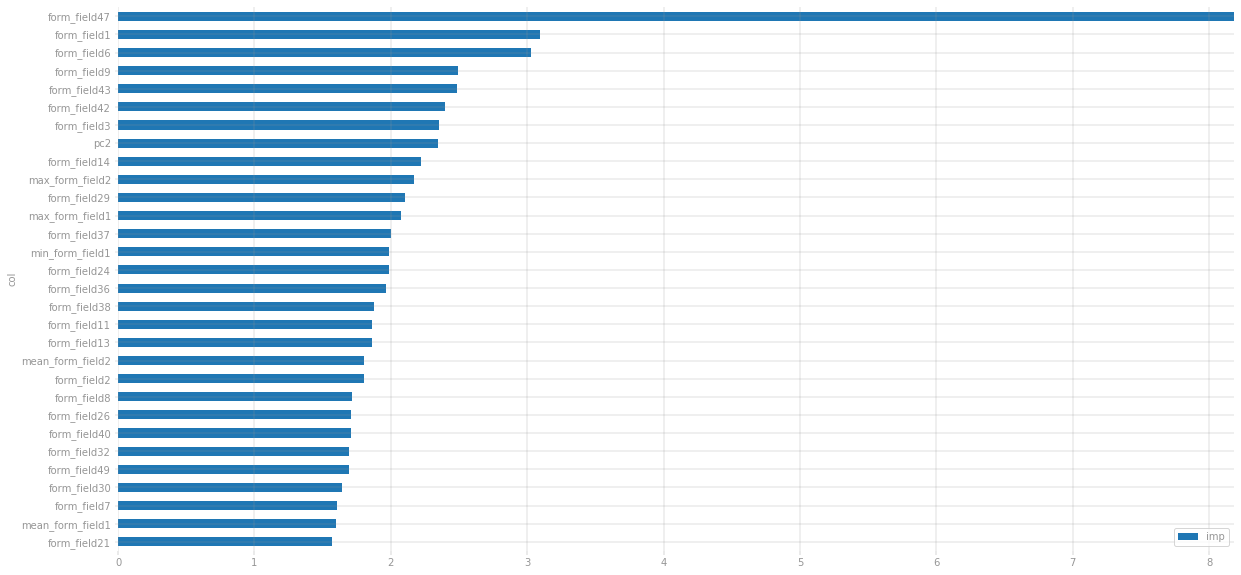

In [32]:
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')

In [33]:
d = {"Applicant_ID": test_id, 'default_status':np.mean(y_pred_totcb, 0)}
test_predictions = pd.DataFrame(data=d)
test_predictions = test_predictions[["Applicant_ID", 'default_status']]

In [34]:
test_predictions.head()

,Applicant_ID,default_status
0,Apcnt_1000032,0.322169
1,Apcnt_1000048,0.346806
2,Apcnt_1000052,0.417816
3,Apcnt_1000076,0.769615
4,Apcnt_1000080,0.179267


In [35]:
test_predictions.to_csv('CATBOOST-3CLUST.csv', index=False)